In [1]:
import numpy as np
from matplotlib import pyplot as plt, colors, cm
import polars as pl
from statsmodels.tsa import stattools as tsatools

In [2]:
import projection_metrics as pms

In [4]:
hb_df = pl.read_csv("./flow_both_14_365/values_harmonic.csv")

In [5]:
def adf_test(series: pl.Series):
    ss = series.to_numpy()
    test = tsatools.adfuller(ss)
    return pl.Series([*test[:4], *test[4].values(), test[5]])

In [6]:
adf_test_df = hb_df.select(pl.col('*').drop_nulls().map(adf_test)).transpose(column_names=[
    'adf',
    'pvalue',
    'lags',
    'nobs',
    'critical value 1%',
    'critical value 5%',
    'critical value 10%',
    'icbest',
]).with_columns(loc=pl.Series(hb_df.columns))

/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [7]:
adf_test_df.shape

(315, 9)

In [8]:
adf_test_df.filter(pl.col('pvalue') > 0.05)

adf,pvalue,lags,nobs,critical value 1%,critical value 5%,critical value 10%,icbest,loc
f64,f64,f64,f64,f64,f64,f64,f64,str
-1.76231,0.399328,7.0,251.0,-3.456674,-2.873125,-2.572944,-1004.009964,"""45.0"""
-0.518109,0.888434,16.0,242.0,-3.457664,-2.873559,-2.573175,-285.639102,"""72.0"""
-1.857871,0.352132,10.0,248.0,-3.456996,-2.873266,-2.573019,-480.28708,"""157.0"""
-2.039996,0.269316,5.0,213.0,-3.461429,-2.875207,-2.574054,-661.064037,"""350.0"""
-2.38541,0.145897,6.0,252.0,-3.456569,-2.873079,-2.572919,-1159.77758,"""403.0"""
-2.258484,0.185707,7.0,251.0,-3.456674,-2.873125,-2.572944,-929.775937,"""680.0"""
-1.209818,0.669358,14.0,226.0,-3.45962,-2.874415,-2.573632,-378.809167,"""844.0"""
-1.610497,0.477715,6.0,252.0,-3.456569,-2.873079,-2.572919,-1084.86936,"""864.0"""
-0.853609,0.802866,13.0,245.0,-3.457326,-2.87341,-2.573096,-318.91992,"""918.0"""


In [9]:
hb_df_mean = hb_df.mean().transpose(column_names=['mean_centrality']).with_columns(pl.Series(hb_df.columns).alias('loc'))

(array([13.,  6.,  7., 13.,  7., 13., 14., 13.,  7.,  4.]),
 array([  1.        ,  32.20000076,  63.40000153,  94.59999847,
        125.80000305, 157.        , 188.19999695, 219.3999939 ,
        250.6000061 , 281.79998779, 313.        ]),
 <BarContainer object of 10 artists>)

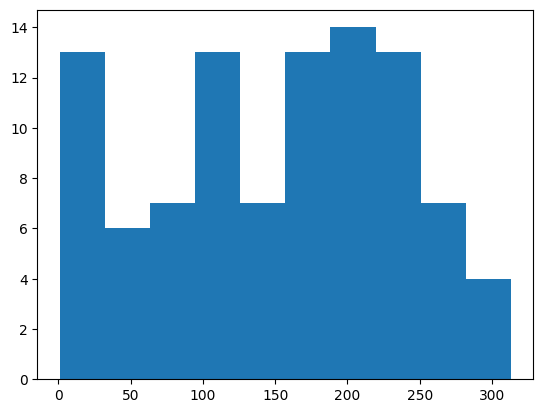

In [10]:
plt.hist(
    hb_df_mean
    .join(adf_test_df, on='loc')
    .with_columns(pl.col('mean_centrality').rank(descending=True).alias('mean_rank'))
    .filter(pl.col('pvalue') > 0.05).select('mean_rank')
    .to_series().to_numpy()
)

Text(0, 0.5, 'Number of Nulls')

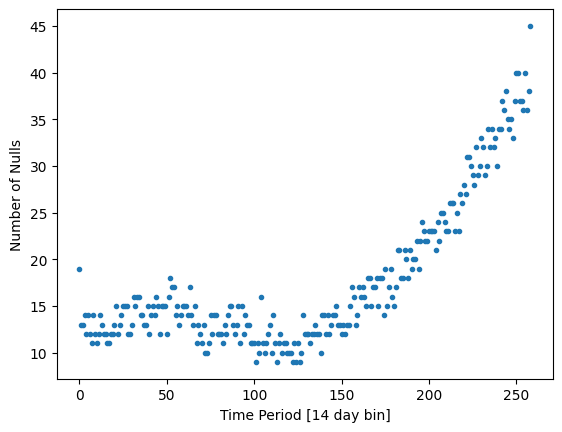

In [17]:
plt.plot(hb_df.transpose().null_count().transpose().to_series().to_numpy()[:-1], '.')
plt.xlabel('Time Period [14 day bin]')
plt.ylabel('Number of Nulls')
# plt.yscale('log')

In [13]:
hb_tf = hb_df.transpose()

descriptors = pl.concat([hb_tf.mean(), hb_tf.var()]).transpose()

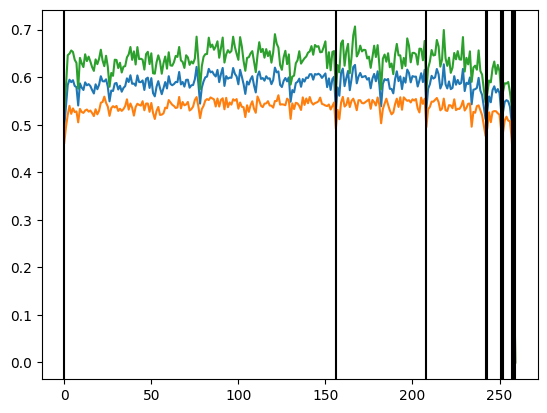

In [18]:
plt.plot(descriptors[:,0])
plt.plot(descriptors[:,0] - 1.96*descriptors[:,1])
plt.plot(descriptors[:,0] + 1.96*descriptors[:,1])
for idx in (
    (descriptors[:,0] < (descriptors[:,0] - 1.96*descriptors[:,1]).mean()) 
    | (descriptors[:,0] > (descriptors[:,0] + 1.96*descriptors[:,1]).mean())
).arg_true().to_list():
# for idx in (descriptors[:,0] < descriptors[:,0].quantile(0.05)).arg_true().to_list():
    plt.axvline(idx, color='k')
    pass

(array([ 1.,  1.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,  7., 11., 12., 17.,
        21., 28., 58., 46., 33., 20., 10., 11.,  7., 12.,  3.,  1.,  4.,
         2.,  3.,  0.,  1.,  1.]),
 array([0.        , 0.03566249, 0.07132499, 0.10698748, 0.14264997,
        0.17831246, 0.21397496, 0.24963745, 0.28529994, 0.32096243,
        0.35662493, 0.39228742, 0.42794991, 0.46361241, 0.4992749 ,
        0.53493739, 0.57059988, 0.60626238, 0.64192487, 0.67758736,
        0.71324985, 0.74891235, 0.78457484, 0.82023733, 0.85589983,
        0.89156232, 0.92722481, 0.9628873 , 0.9985498 , 1.03421229,
        1.06987478, 1.10553727]),
 <BarContainer object of 31 artists>)

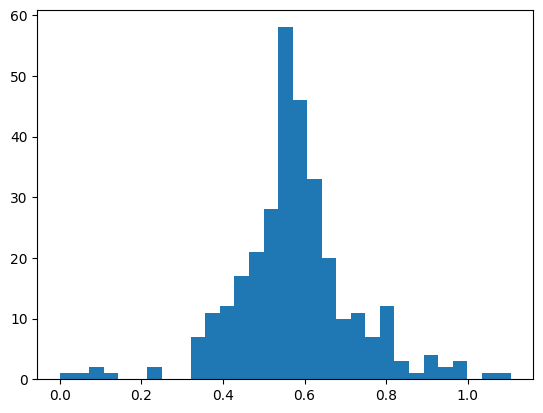

In [21]:
plt.hist(hb_df.mean().transpose().to_series(), bins=31)